# Find wheels and rims in images, write rims as json file ##

Develop techniques for finding wheels (connected regions) in images and the rims that surround them.

## Read image from file 

In [25]:
import datetime
now = datetime.datetime.now()
startNB = now
print("Date and time ",str(now))
#
import sys
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
#
# Control batch file numbers from  0001 to 0020
# Irradiated batch file numbers from 0001 to 0020
#imFile = "Images/ControlBatch/0020.bmp"
imFile = "Images/IrradiatedBatch/0020.bmp"
#
# Combining error in e.g. Control 0013, Irradiated 0013, Irradiated 0018
# Evidence tuning needed in e.g. Control 0020, Irradiated 0015, Irradiated 0018
#
# Read in image
imgRaw = plt.imread(imFile)
#
print(" ")
print("File " + imFile + " read.")
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-01-29 17:22:13.830229
 
File Images/IrradiatedBatch/0020.bmp read.
 
Date and time 2021-01-29 17:22:13.842203
Time since last check is 0:00:00.011974


## Routines for converting RGBA images to RGB and RGB to greyscale

In [26]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import numpy as np
#
def rgba2rgb(rgba, background = (255, 255, 255)):
    '''
    Function to convert RGBA images into RGB format. Input RGBA image (and background); output RGB image.
    '''
    rows, cols, chans = rgba.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
            return rgba
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 4, 'RGBA image must have 4 channels.'
    #
    rgb = np.zeros((rows, cols, 3), dtype = 'float32')
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    #
    a = np.asarray(a, dtype='float32')/255.0
    #
    R, G, B = background
    #
    rgb[:, :, 0] = r*a + (1.0 - a)*R
    rgb[:, :, 1] = g*a + (1.0 - a)*G
    rgb[:, :, 2] = b*a + (1.0 - a)*B
    #
    return np.asarray(rgb, dtype = np.uint8)
#
def rgb2grey(rgb, negative = 0):
    '''
    Convert RGB image to greyscale. Input RGB (and flag indicating negative required), output greyscale image.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #
    grey[:, :] = (0.2125*(r*negative + (negative - 1.0)*r) + 
                  0.7154*(g*negative + (negative - 1.0)*g) + 
                  0.0721*(b*negative + (negative - 1.0)*b))
    #
    return np.asarray(grey, dtype = np.uint8)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-01-29 17:22:13.858153
 
Date and time 2021-01-29 17:22:13.858153
Time since last check is 0:00:00


## Ceiling division

In [27]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
def ceilDiv(a, b):
    '''
    Return a//b rounded up.
    '''
    ceiling = -(-a//b)
    return ceiling
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-01-29 17:22:13.867095
 
Date and time 2021-01-29 17:22:13.868092
Time since last check is 0:00:00.000997


## Initial image processing

Open image, convert to grey scale and apply a range of increasing thresholds.

Date and time  2021-01-29 17:22:13.897045
Type of raw image file is uint8
Type of greyscale image file is uint8
Number of rows 1040 of columns 1392 of pixels 1447680 and depth 4
Maximum value in pixels 244
 
Number of thresholds 2
Number of rows in figure 3
 


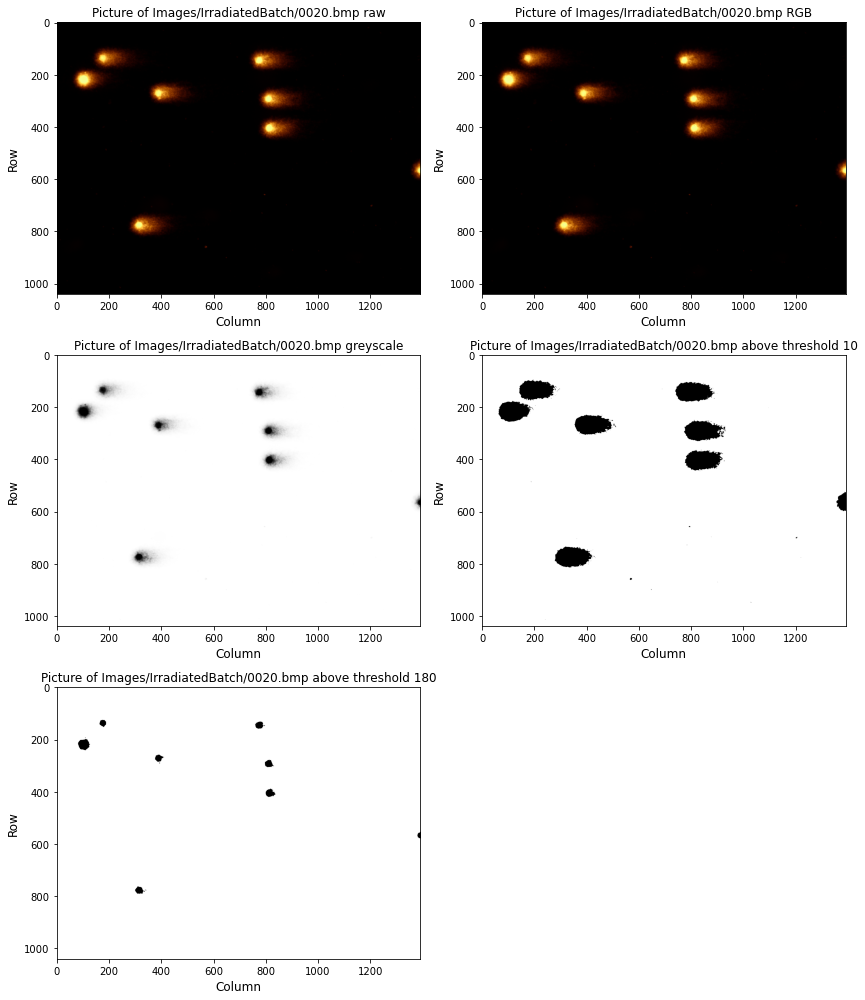

 
Date and time 2021-01-29 17:22:15.774889
Time since last check is 0:00:01.877844


In [28]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import sys
import numpy as np
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
# 
# Number of rows and columns. Depth is 3 for RGB, 4 for RGBA image. A is opacity (alpha)
nRows = imgRaw.shape[0] 
nCols = imgRaw.shape[1]
nDepth = imgRaw.shape[2]
img = np.zeros((nRows, nCols))
#
# Determine image format and process accordingly
if nDepth == 4:
    imgRGB = rgba2rgb(imgRaw)
    imgGrey = rgb2grey(imgRGB, 1)
elif nDepth == 3:
    imgRGB = imgRaw
    imgGrey = rgb2grey(imgRGB, 1)
elif nDepth == 1:
    imgRGB = imgRaw
    imgGrey = imgRaw
else:
    print(" ")
    print("Unexpected image depth",nDepth)
    sys.stop()
#
print("Type of raw image file is",imgRaw.dtype)
print("Type of greyscale image file is",imgGrey.dtype)
print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols,"and depth",nDepth)
print("Maximum value in pixels",np.amax(imgGrey))
#
# Set thresholds for applying to image (lowest to highest)
thresh = np.array([10, 180]) 
nThresh = len(thresh)
imgThr = np.zeros((nRows, nCols, nThresh))
#
# Plot image at various stages of processing
nFigRows = 2 + ceilDiv(nThresh, 2)
print(" ")
print("Number of thresholds",nThresh)
print("Number of rows in figure",nFigRows)
for nT in range(0, nThresh):
    imgThr[:, :, nT] = imgGrey > thresh[nT]
#
print(" ")
fig = plt.figure(figsize=(nFigRows*4, 14))
fig.add_subplot(nFigRows, 2, 1)
plt.title("Picture of " + imFile + " raw")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgRaw, cmap = "jet")
#
fig.add_subplot(nFigRows, 2, 2)
plt.title("Picture of " + imFile + " RGB")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgRGB, cmap = "jet")
#
fig.add_subplot(nFigRows, 2, 3)
plt.title("Picture of " + imFile + " greyscale")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgGrey, cmap = "Greys")
#
for nT in range(0, nThresh):
    fig.add_subplot(nFigRows, 2, 4 + nT)
    plt.title("Picture of " + imFile + " above threshold " + str(thresh[nT]))
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    imgplot = plt.imshow(imgThr[:, :, nT], cmap = "Greys")
#
plt.tight_layout()
plt.savefig("imageD.png")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Edge finding

Algorithm used is to shift logical array `picture` containing thresholded image left and right, forming array `imgL` and `imgR`. The arrays `imgL and (not picture)` and `imgR and (not picture)` then contain the left and right edges in the original image. Similarly, `imgU and (not picture)` and `imgD and (not picture)` contain the upper and lower egdes. Taking the logical or of these four arrays gives all edges.

Date and time 2021-01-29 17:22:15.792808
 
Number of figure rows 1
 
Number of points in edges, threshold 10, is 3985
Number of points in edges, threshold 180, is 812
 


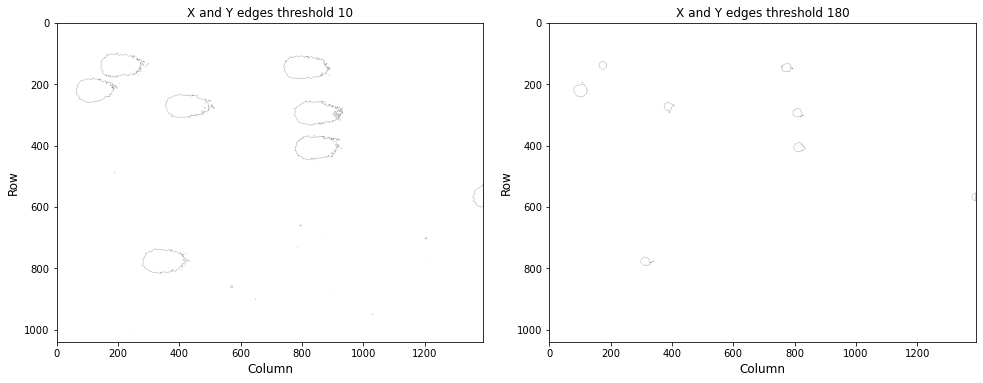

 
Date and time 2021-01-29 17:22:16.267538
Time since last check is 0:00:00.474730


In [29]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
def edgeFinder(picture, edgeWidth):
    '''
    Return array containing pixels in edges (of width edgeWidth) of input (thresholded) image.
    '''
    #
    shiftR = edgeWidth
    shiftC = edgeWidth
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    imgL = np.full((nRows, nCols), False)
    imgR = np.full((nRows, nCols), False)
    imgD = np.full((nRows, nCols), False)
    imgU = np.full((nRows, nCols), False)
    #
    imgL[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
    imgL[0:nRows, nCols - shiftC:nCols] = False
    imgR[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
    imgR[0:nRows, 0:shiftC] = False
    imgD[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]
    imgD[nRows - shiftR:nRows, 0:nCols] = False
    imgU[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
    imgU[0:shiftR, 0:nCols] = False
    #
    edges = (np.logical_or(np.logical_or(np.logical_and(picture, np.logical_not(imgR)), # left edge
                                         np.logical_and(picture, np.logical_not(imgL))), # right edge
                           np.logical_or(np.logical_and(picture, np.logical_not(imgU)), # upper edge
                                         np.logical_and(picture, np.logical_not(imgD))))) # lower edge
    #
    return edges
#
width = 1
nFigRows = ceilDiv(nThresh, 2)
print(" ")
print("Number of figure rows",nFigRows)
#
imgEdge = np.zeros((nRows, nCols, nThresh)).astype(bool)
#
fig = plt.figure(figsize=(14, nFigRows*10))
print(" ")
for nT in range(0, nThresh):
    imgEdge[:, :, nT] = edgeFinder(imgThr[:, :, nT], width)
    print("Number of points in edges, threshold",thresh[nT],"\b, is",np.sum(imgEdge[:, :, nT]))
    #
    plt.subplot(nFigRows + 1, 2, nT + 1)
    plt.title("X and Y edges threshold " + str(thresh[nT]), fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    plt.imshow(imgEdge[:, :, nT], cmap = "Greys")
#
print(" ")
plt.tight_layout()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Wheel search

Link the pixels in the thresholded images to form "wheels". Algorithm is as follows:

Set the rim label `nWheel` to its start value.  
For each pixel:  
1 Define a maximum search region around the pixel (using distance `mSep`).   
2 If there are labelled neighbouring pixels in this region:  
2.1 Start from the smallest possible box around the pixel (using distance `sep`).  
2.2 If there are labelled neighbouring pixels in the box, find the median of the labels and set the label of the current pixel to that label.  
3 Else:  
3.1 Set the pixel label to the current value of `nWheel` .    
3.2 Increase the value of `nWheel` .     
4 Move to next pixel.

Here, search regions are boxes. Using circular regions has been explored (see `RimsCircleSearch`), but no performance improvement is seen and the routine is significantly slower.

Date and time 2021-01-29 17:22:16.355266
 
Maximum search separation is 20
Number of wheels found at threshold 10 is 25
Number of wheels found at threshold 180 is 8
 
Total number of points in wheels at threshold 10 is 60102
Max. number of points in a wheel is 8570
 
 
Total number of points in wheels at threshold 180 is 5773
Max. number of points in a wheel is 1443
 


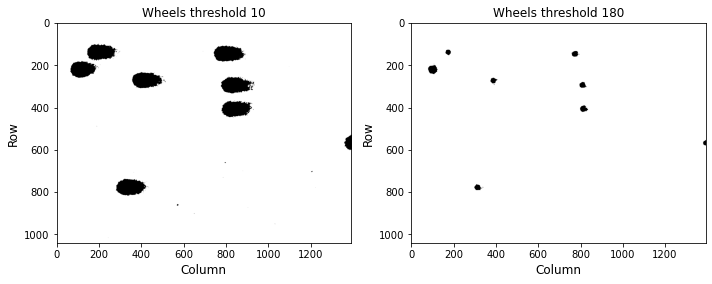

 
Total number of points in rims at threshold 10 is 3985
Max number of points in a rim is 581
 
 
Total number of points in rims at threshold 180 is 812
Max number of points in a rim is 139
 


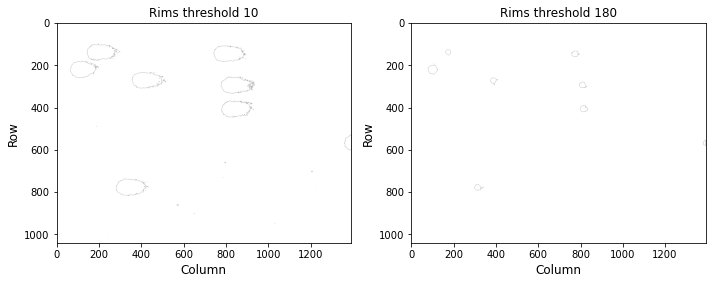

 
Date and time 2021-01-29 17:22:21.477695
Time since last check is 0:00:05.122429


In [30]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
#
def wheelSearch(picture, edges, mSep):
    #
    nRow, nCols = picture.shape
    patchArr = np.full((2*mSep + 1, 2*mSep + 1), -1)
    subPatchArr = np.full((2*mSep + 1, 2*mSep + 1), -1)
    wheelNum = np.full((nRows, nCols), -1)
    rimNum = np.full((nRows, nCols), -1)
    #
    nWheel = 0
    for r in range(0, nRows):
        for c in range(0, nCols):
            #
            # Check if pixel hit, and whether already assigned to wheel
            if not picture[r, c] or wheelNum[r, c] > -1: 
                continue
            #
            # Set up local "patch" surrounding pixel and fill with local image data
            mSepRbot = max(r - mSep, 0)
            mSepRtop = min(r + mSep + 1, nRows)
            mSepCbot = max(c - mSep, 0)
            mSepCtop = min(c + mSep + 1, nCols)
            patchArr[0:mSepRtop - mSepRbot, 0:mSepCtop - mSepCbot] = wheelNum[mSepRbot:mSepRtop, mSepCbot:mSepCtop]
            patchNum = -1
            #
            # Check if any pixels in the patch have already been assigned to wheels
            posPatch = patchArr > -1
            if np.sum(posPatch) > 0:
                #
                # Define a "sub-patch" around the pixel, going from minimum to maximum size
                subPatchArr[0:2*mSep + 1, 0:2*mSep + 1] = -1
                for sep in range(1, mSep):
                    sepRbot = max(r - mSep, 0)
                    sepRtop = min(r + mSep + 1, nRows)
                    sepCbot = max(c - mSep, 0)
                    sepCtop = min(c + mSep + 1, nCols)
                    subPatchArr[0:sepRtop - sepRbot, 0:sepCtop - sepCbot] = wheelNum[sepRbot:sepRtop, sepCbot:sepCtop]
                    posSubPatch = subPatchArr > -1
                    #
                    # If there are wheel indices in the sub-patch, set the current wheel number to the median of these
                    if np.sum(posSubPatch) > 0:
                        patchNum = np.median(subPatchArr[posSubPatch])
                        break
                    #  
                #
            #  If assigned wheel index, set the pixel to belong to this wheel (ditto for rim) 
            if patchNum > -1:
                wheelNum[r, c] = patchNum
                if edges[r, c]:
                    rimNum[r, c] = patchNum
            else:
                #
                # If no assigned wheel index, set pixel to belong to new wheel and rim and increase wheel index 
                wheelNum[r, c] = nWheel
                if edges[r, c]:
                    rimNum[r, c] = nWheel
                nWheel += 1
            #
        #
    return nWheel, wheelNum, rimNum
#
maxSep = 20
nWheel = np.zeros(nThresh).astype(int)
wheelNum = np.zeros((nRows, nCols, nThresh))
rimNum = np.zeros((nRows, nCols, nThresh))
#
thisWheel = np.zeros((nRows, nCols))
print(" ")
print("Maximum search separation is",maxSep)
for nT in range(0, nThresh):
    nWheel[nT], wheelNum[:, :, nT], rimNum[:, :, nT] =  \
        wheelSearch(imgThr[:, :, nT], imgEdge[:, :, nT], maxSep)
    print("Number of wheels found at threshold",thresh[nT],"is",nWheel[nT])
#
nWheelPnts = np.zeros((np.amax(nWheel), nThresh)).astype(int)
maxWheelPnts = np.zeros(nThresh).astype(int)
#
fig = plt.figure(figsize = (nFigRows*10, 14))
for nT in range(0, nThresh):
    allWheels = np.full((nRows, nCols), False)
    plt.subplot(nFigRows, 2, nT + 1)
    plt.title("Wheels threshold " + str(thresh[nT]), fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    #
    if debug:
        print(" ")
        print("Index\t Wheel area")
    for iWheel in range(0, nWheel[nT]):
        thisWheel = wheelNum[:, :, nT] == iWheel
        nWheelPnts[iWheel, nT] = np.sum(thisWheel)
        if debug:
            print("{:d}\t {:d}".format(iWheel, nWheelPnts[iWheel, nT]))
        allWheels = np.logical_or(thisWheel, allWheels)
    #
    maxWheelPnts[nT] = np.amax(nWheelPnts[:, nT])
    print(" ")
    print("Total number of points in wheels at threshold",thresh[nT],"is",np.sum(allWheels))
    print("Max. number of points in a wheel is",maxWheelPnts[nT])
    #
    print(" ")
    plt.imshow(allWheels, cmap = 'Greys')
#
plt.tight_layout()
plt.show()
#
nRim = nWheel
thisRim = np.zeros((nRows, nCols))
#
nRimPnts = np.zeros((np.amax(nWheel), nThresh)).astype(int)
maxRimPnts = np.zeros(nThresh).astype(int)
#
fig = plt.figure(figsize = (nFigRows*10, 14))
for nT in range(0, nThresh):
    allRims = np.full((nRows, nCols),False)
    plt.subplot(nFigRows, 2, nT + 1)
    plt.title("Rims threshold " + str(thresh[nT]), fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    #
    if debug:
        print(" ")
        print("Index\t Rim length")
    for iRim in range(0, nRim[nT]):
        thisRim = rimNum[:, :, nT] == iRim
        nRimPnts[iRim, nT] = np.sum(thisRim)
        if debug:
            print("{:d}\t {:d}".format(iRim, nRimPnts[iRim, nT]))
        allRims = np.logical_or(thisRim, allRims)
    #
    maxRimPnts[nT] = np.amax(nRimPnts[:, nT])
    print(" ")
    print("Total number of points in rims at threshold",thresh[nT],"is",np.sum(allRims))
    print("Max number of points in a rim is",maxRimPnts[nT])
    #
    print(" ")
    plt.imshow(allRims, cmap = 'Greys')
#
plt.tight_layout()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Group wheel pixels

Make arrays containing the row and column positions of the points in each of the wheels.

Date and time 2021-01-29 17:22:21.495228
 


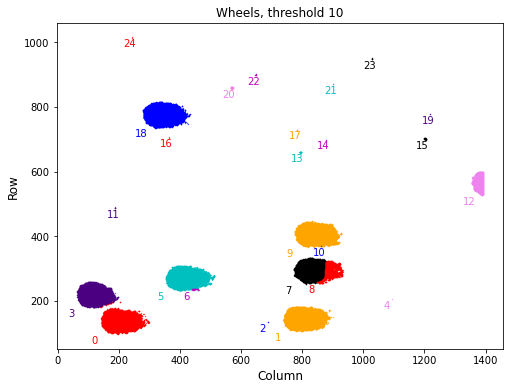

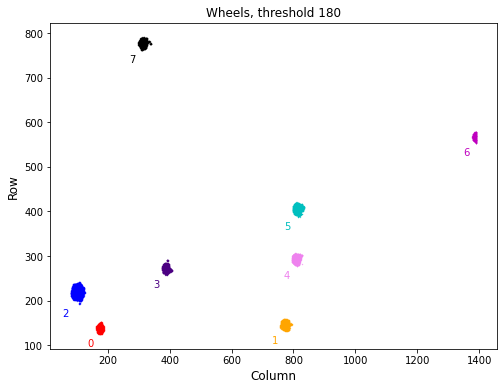

 
Date and time 2021-01-29 17:22:22.365847
Time since last check is 0:00:00.870619


In [31]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
# 
wheelR = np.zeros((np.amax(nWheel), np.amax(maxWheelPnts), nThresh))
wheelC = np.zeros((np.amax(nWheel), np.amax(maxWheelPnts), nThresh))
for nT in range(0, nThresh):
    for iWheel in range(0, nWheel[nT]):
        thisWheel = wheelNum[:, :, nT] == iWheel
        wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT] = np.where(thisWheel)[0]
        wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT] = np.where(thisWheel)[1]
#
nColors = 8
colList = ['r', 'orange', 'b', 'indigo', 'violet', 'c', 'm', 'k']
wTextRow = 28
wTextCol = 28
#
minWheelPnts = 1
# 
for nT in range(0, nThresh):
    print(" ")
    fig = plt.figure(figsize=(8, 6))
    plt.title("Wheels, threshold " + str(thresh[nT]), fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    iCol = 0
    #
    for iWheel in range(0, nWheel[nT]):
        if nWheelPnts[iWheel, nT] < minWheelPnts:
            continue
        plt.scatter(wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT], wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT], 
                    s = 0.1, color = colList[iCol])
        rLab = np.amin(wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT]) - wTextRow
        cLab = np.amin(wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT]) - wTextCol
        plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
        iCol = iCol + 1
        if iCol > nColors - 1:
            iCol = 0
        #
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Group rim pixels

Make arrays containing the row and column positions of the points belonging to each of the rims.

Date and time 2021-01-29 17:22:22.380804
 


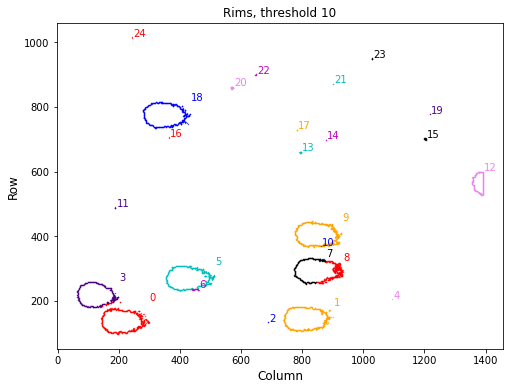

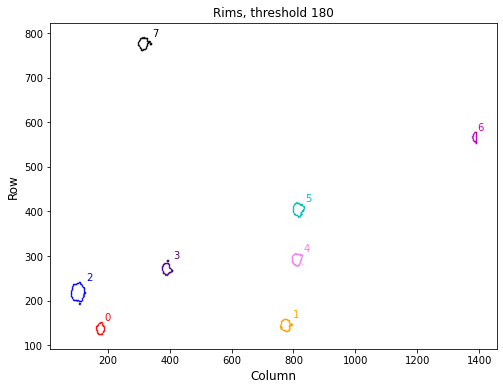

 
Date and time 2021-01-29 17:22:23.225452
Time since last check is 0:00:00.844648


In [32]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
# 
rimR = np.zeros((np.amax(nRim), np.amax(maxRimPnts), nThresh))
rimC = np.zeros((np.amax(nRim), np.amax(maxRimPnts), nThresh))
for nT in range(0, nThresh):
    for iRim in range(0, nRim[nT]):
        thisRim = rimNum[:, :, nT] == iRim
        rimR[iRim, 0:nRimPnts[iRim, nT], nT] = np.where(thisRim)[0]
        rimC[iRim, 0:nRimPnts[iRim, nT], nT] = np.where(thisRim)[1]
#
minRimPnts = 1
rTextRow = 3
rTextCol = 3
# 
for nT in range(0, nThresh):
    print(" ")
    fig = plt.figure(figsize=(8, 6))
    plt.title("Rims, threshold " + str(thresh[nT]), fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    iCol = 0
    #
    for iRim in range(0, nRim[nT]):
        if nRimPnts[iRim, nT] < minRimPnts:
            continue
        plt.scatter(rimC[iRim, 0:nRimPnts[iRim, nT], nT], rimR[iRim, 0:nRimPnts[iRim, nT], nT], 
                    s = 0.1, color = colList[iCol])
        rLab = np.amax(rimR[iRim, 0:nRimPnts[iRim, nT], nT]) + rTextRow
        cLab = np.amax(rimC[iRim, 0:nRimPnts[iRim, nT], nT]) + rTextCol
        plt.text(cLab, rLab, str(iRim), color = colList[iCol])
        iCol = iCol + 1
        if iCol > nColors - 1:
            iCol = 0
        #
    plt.show()
#
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot rims and wheels together

Date and time 2021-01-29 17:22:23.251416
 
	 Rim length	 Wheel area	 Rim length/Wheel area
Means	 159.4		 2404.1		 0.07
 


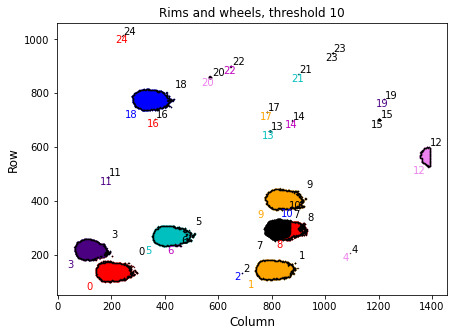

 
	 Rim length	 Wheel area	 Rim length/Wheel area
Means	 32.5		 230.9		 0.14
 


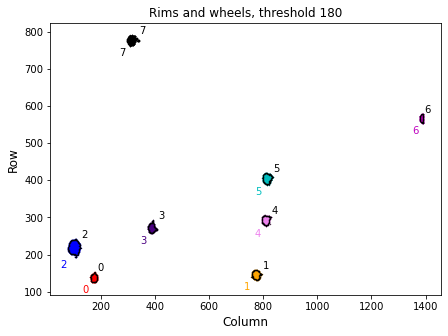

 
Date and time 2021-01-29 17:22:24.264600
Time since last check is 0:00:01.013184


In [33]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
#
minWheelPnts = 1
minRimPnts = 1
withLabels = True
#
for nT in range(0, nThresh):
    print(" ")
    fig = plt.figure(figsize=(7, 5))
    plt.title("Rims and wheels, threshold " + str(thresh[nT]), fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    #
    iCol = 0
    #
    if debug:
        print(" ")
        print("Threshold",thresh[nT])
        print("Index\t Rim length\t Wheel area\t Rim length/Wheel area")
    for iWheel in range(0, nWheel[nT]):
        if nWheelPnts[iWheel, nT] >  minWheelPnts - 1:
            plt.scatter(wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT], wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT], 
                        s = 0.1, color = colList[iCol])
            if withLabels:
                rLab = np.amin(wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT]) - wTextRow
                cLab = np.amin(wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT]) - wTextCol
                plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
            iCol = iCol + 1
            if iCol > nColors - 1:
                iCol = 0
            #
        if nRimPnts[iWheel, nT] > minRimPnts - 1:
            plt.scatter(rimC[iWheel, 0:nRimPnts[iWheel, nT], nT], rimR[iWheel, 0:nRimPnts[iWheel, nT], nT], 
                        s = 0.1, color = 'k')
            if withLabels:
                rLab = np.amax(rimR[iWheel, 0:nRimPnts[iWheel, nT], nT]) + rTextRow
                cLab = np.amax(rimC[iWheel, 0:nRimPnts[iWheel, nT], nT]) + rTextCol
                plt.text(cLab, rLab, str(iWheel), color = 'k')
        if debug:
            print("{:d}\t {:d}\t\t {:d}\t\t {:.2f}".
                  format(iWheel, nRimPnts[iWheel, nT], nWheelPnts[iWheel, nT], 
                         nRimPnts[iWheel, nT]/nWheelPnts[iWheel, nT]))
    print("\t Rim length\t Wheel area\t Rim length/Wheel area")
    print("Means\t {:.1f}\t\t {:.1f}\t\t {:.2f}".
          format(np.mean(nRimPnts[:, nT]), np.mean(nWheelPnts[:, nT]), 
                 np.mean(nRimPnts[:, nT])/np.mean(nWheelPnts[:, nT])))
    #
    print(" ")
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Identify adjacent wheels and rims

Using rims, identify immediately adjacent wheels and rims (i.e. those that very probably should be seen as being a single wheel/rim). Two rims are considered immediately adjacent if the closest pixels in the rims are within one pixel width $w = 1$ (including diagonal, i.e. $\sqrt{2} w$). Keep track of the maximum number of wheels/rims identified as being adjacent.

In [34]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
print(" ")
print("Combine wheels and rims using rims")
#
relabelR = np.zeros((np.amax(nRim), nThresh)).astype(int)
nRimN = np.zeros(nThresh).astype(int)
nWheelN = np.zeros(nThresh).astype(int)
#
maxMult = 0
for nT in range(0, nThresh):
    relabelR[0:nRim[nT], nT] = np.linspace(0, nRim[nT] - 1, nRim[nT]).astype(int)
    label = 0
    mult = 1
    for iRim in range(0, nRim[nT] - 1):
        minDist = nRows + nCols
        for iPnt in range(0, nRimPnts[iRim, nT]):
            for jPnt in range(0, nRimPnts[iRim + 1, nT]):
                dist = np.sqrt((rimC[iRim, iPnt, nT] - rimC[iRim + 1, jPnt, nT])**2 + 
                               (rimR[iRim, iPnt, nT] - rimR[iRim + 1, jPnt, nT])**2)
                minDist = min(minDist, dist)
        if debug:
            print(" ")
            print("iRim",iRim,"minDist",minDist)
        if minDist < 1.5:
            mult += 1
            relabelR[iRim + 1, nT] = label
        else:
            label += 1
            relabelR[iRim + 1, nT] = label
        #
        maxMult = max(maxMult, mult)
    #
    if debug:
        print(" ")
        print("Threshold",thresh[nT])
        print("Relabelling of rims:")
        print("Old\t New")
        for iRim in range(0, nRim[nT]):
            print("{:d}\t {:d}".format(iRim, relabelR[iRim, nT]))
    #
    nRimN[nT] = relabelR[nRim[nT] - 1, nT] + 1
    nWheelN[nT] = relabelR[nRim[nT] - 1, nT] + 1
    if debug:
        print(" ")
        print("New number of rims",nRimN[nT],"new number of wheels",nWheelN[nT])
    else:
        print("Threshold",thresh[nT])
        print("New number of rims",nRimN[nT],"new number of wheels",nWheelN[nT])
#
print(" ")
print("Maximum number of wheels and rims that are adjacent",maxMult)
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2021-01-29 17:22:24.339429
 
Combine wheels and rims using rims
Threshold 10
New number of rims 22 new number of wheels 22
Threshold 180
New number of rims 8 new number of wheels 8
 
Maximum number of wheels and rims that are adjacent 4
 
Date and time 2021-01-29 17:22:26.951227
Time since last check is 0:00:02.611798


## Relabel wheels and rims 

Relabel wheels and rims, giving them the same label if they are adjacent. Set the new label to be the that of the lower of the adjacent pair. Fill arrays containing the positions of the pixels in the combined wheels and rims.

In [35]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
# Make new wheel/rim row and wheel/rim column arrays big enough to hold information on the combined wheels/rims. 
# Many of these arrays will be have lots of empty space in them!
nRimPntsN = np.zeros((np.amax(nRim), nThresh)).astype(int)
nWheelPntsN = np.zeros((np.amax(nRim), nThresh)).astype(int)
rimRN = np.zeros((np.amax(nRim), maxMult*np.amax(maxRimPnts), nThresh))
rimCN = np.zeros((np.amax(nRim), maxMult*np.amax(maxRimPnts), nThresh))
wheelRN = np.zeros((np.amax(nWheel), maxMult*np.amax(maxWheelPnts), nThresh))
wheelCN = np.zeros((np.amax(nWheel), maxMult*np.amax(maxWheelPnts), nThresh))
#
for nT in range(0, nThresh):
    thisWheel = 0
    oldRimPnts = 0
    oldWheelPnts = 0
    for iWheel in range(0, nWheel[nT]):
        if relabelR[iWheel, nT] != thisWheel:
            thisWheel += 1
            oldRimPnts = 0
            oldWheelPnts = 0
        newRimPnts = nRimPntsN[thisWheel, nT] + nRimPnts[iWheel, nT]
        newWheelPnts = nWheelPntsN[thisWheel, nT] + nWheelPnts[iWheel, nT]
        rimRN[thisWheel, oldRimPnts:newRimPnts, nT] = rimR[iWheel, 0:nRimPnts[iWheel, nT], nT] 
        rimCN[thisWheel, oldRimPnts:newRimPnts, nT] = rimC[iWheel, 0:nRimPnts[iWheel, nT], nT]
        wheelRN[thisWheel, oldWheelPnts:newWheelPnts, nT] = wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT] 
        wheelCN[thisWheel, oldWheelPnts:newWheelPnts, nT] = wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT] 
        oldRimPnts = newRimPnts
        oldWheelPnts = newWheelPnts
        nRimPntsN[thisWheel, nT] = newRimPnts
        nWheelPntsN[thisWheel, nT] = newWheelPnts        
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2021-01-29 17:22:26.968214
 
Date and time 2021-01-29 17:22:26.972170
Time since last check is 0:00:00.003956


## Plot combined wheels

Date and time 2021-01-29 17:22:26.983174
 


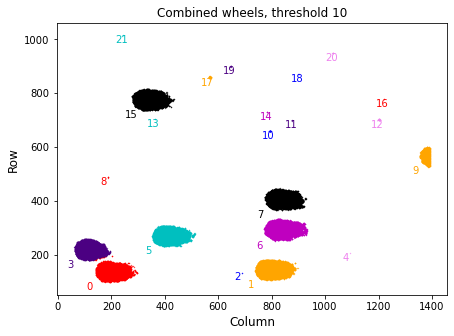

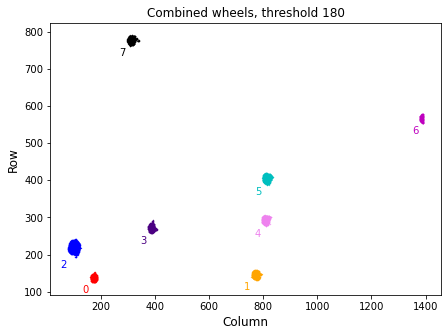

 
Date and time 2021-01-29 17:22:27.531633
Time since last check is 0:00:00.548459


In [36]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
print(" ")
#
minWheelPnts = 1
minRimPnts = 1
#
for nT in range (0, nThresh):
    fig = plt.figure(figsize=(7.0, 5.0))
    plt.title("Combined wheels, threshold " + str(thresh[nT]), fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    iCol = 0
    for iWheel in range(0, nWheelN[nT]):
        if nWheelPntsN[iWheel, nT] < minWheelPnts or nRimPntsN[iWheel, nT] < minRimPnts:
            continue
        plt.scatter(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], 
                    s = 0.1, color = colList[iCol])
        rLab = np.amin(wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT]) - wTextRow
        cLab = np.amin(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT]) - wTextCol
        plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
        iCol = iCol + 1
        if iCol > nColors - 1:
            iCol = 0
#
plt.show()
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot combined rims

Date and time 2021-01-29 17:22:27.550613
 


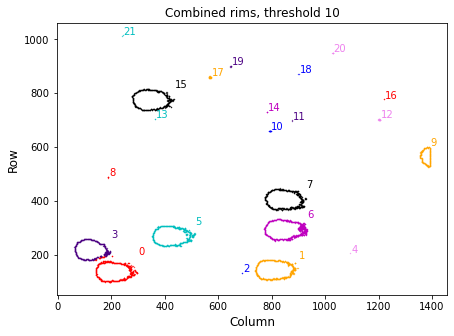

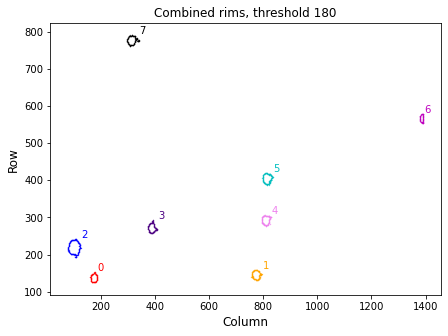

 
Date and time 2021-01-29 17:22:28.070165
Time since last check is 0:00:00.519552


In [37]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
print(" ")
#
minWheelPnts = 1
minRimPnts = 1
#
for nT in range (0, nThresh):
    fig = plt.figure(figsize=(7.0, 5.0))
    plt.title("Combined rims, threshold " + str(thresh[nT]), fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    iCol = 0
    for iRim in range(0, nRimN[nT]):
        if nWheelPntsN[iRim, nT] < minWheelPnts or nRimPntsN[iRim, nT] < minRimPnts:
            continue
        plt.scatter(rimCN[iRim, 0:nRimPntsN[iRim, nT], nT], rimRN[iRim, 0:nRimPntsN[iRim, nT], nT], 
                    s = 0.1, color = colList[iCol])
        rLab = np.amax(rimRN[iRim, 0:nRimPntsN[iRim, nT], nT]) + rTextRow
        cLab = np.amax(rimCN[iRim, 0:nRimPntsN[iRim, nT], nT]) + rTextCol
        plt.text(cLab, rLab, str(iRim), color = colList[iCol])
        iCol = iCol + 1
        if iCol > nColors - 1:
            iCol = 0
#
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot combined wheels and rims together, for each threshold

Date and time 2021-01-29 17:22:28.094124
 
	 Rim Length	 Wheel area
Means	 327.5		 4343.0
 


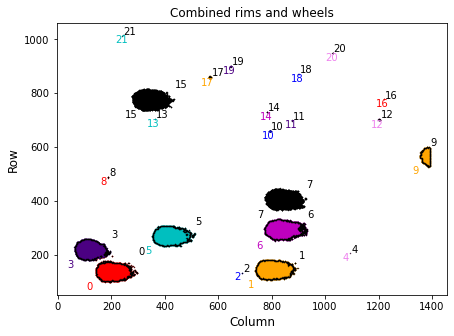

	 Rim Length	 Wheel area
Means	 299.5		 4633.5
 


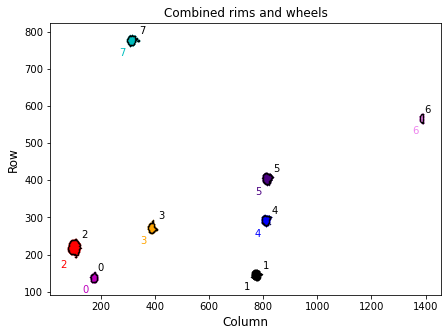

 
Date and time 2021-01-29 17:22:29.031386
Time since last check is 0:00:00.937262


In [38]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
#
print(" ")
#
minWheelPnts = 1
minRimPnts = 1
iCol = 0
#
withLabels = True
#
for nT in range(0, nThresh):
    fig = plt.figure(figsize=(7.0, 5.0))
    plt.title("Combined rims and wheels", fontsize = 12)
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    if debug:
        print(" ")
        print("Index\t Rim Length\t Wheel area")
    for iWheel in range(0, nWheelN[nT]):
        if nWheelPntsN[iWheel, nT] >  minWheelPnts - 1 and nRimPntsN[iWheel, nT] > minRimPnts - 1:
            plt.scatter(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], 
                        s = 0.1, color = colList[iCol])
            if withLabels:
                rLab = np.amin(wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT]) - wTextRow
                cLab = np.amin(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT]) - wTextCol
                plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
            iCol = iCol + 1
            if iCol > nColors - 1:
                iCol = 0
            #
            plt.scatter(rimCN[iWheel, 0:nRimPntsN[iWheel, nT], nT], rimRN[iWheel, 0:nRimPntsN[iWheel, nT], nT], 
                        s = 0.1, color = 'k')
            if withLabels:
                rLab = np.amax(rimRN[iWheel, 0:nRimPntsN[iWheel, nT], nT]) + rTextRow
                cLab = np.amax(rimCN[iWheel, 0:nRimPntsN[iWheel, nT], nT]) + rTextCol
                plt.text(cLab, rLab, str(iWheel), color = 'k')
            if debug:
                print("{:d}\t {:d}\t\t {:d}".
                      format(iWheel, nRimPntsN[iWheel, nT], nWheelPntsN[iWheel, nT]))
    print("\t Rim Length\t Wheel area")
    print("Means\t {:.1f}\t\t {:.1f}".
          format(np.mean(nRimPntsN[nT]), np.mean(nWheelPntsN[nT])))
    #
    print(" ")
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot combined wheels and rims together, all thresholds

Date and time 2021-01-29 17:22:29.055321
 
	 Rim Length	 Wheel area
Means	 327.5		 4343.0
	 Rim Length	 Wheel area
Means	 299.5		 4633.5
 


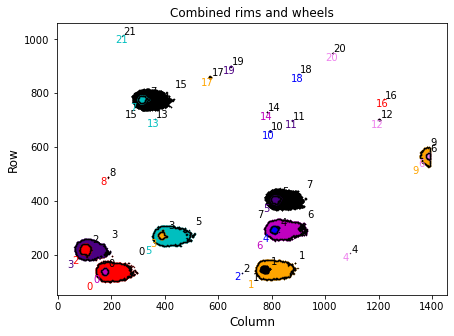

 
Date and time 2021-01-29 17:22:29.980780
Time since last check is 0:00:00.925459


In [39]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
#
print(" ")
#
minWheelPnts = 1
minRimPnts = 1
iCol = 0
#
withLabels = True
#
fig = plt.figure(figsize=(7.0, 5.0))
plt.title("Combined rims and wheels", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
for nT in range(0, nThresh):
    if debug:
        print(" ")
        print("Index\t Rim Length\t Wheel area")
    for iWheel in range(0, nWheelN[nT]):
        if nWheelPntsN[iWheel, nT] >  minWheelPnts - 1 and nRimPntsN[iWheel, nT] > minRimPnts - 1:
            plt.scatter(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], 
                        s = 0.1, color = colList[iCol])
            if withLabels:
                rLab = np.amin(wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT]) - wTextRow
                cLab = np.amin(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT]) - wTextCol
                plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
            iCol = iCol + 1
            if iCol > nColors - 1:
                iCol = 0
            #
            plt.scatter(rimCN[iWheel, 0:nRimPntsN[iWheel, nT], nT], rimRN[iWheel, 0:nRimPntsN[iWheel, nT], nT], 
                        s = 0.1, color = 'k')
            if withLabels:
                rLab = np.amax(rimRN[iWheel, 0:nRimPntsN[iWheel, nT], nT]) + rTextRow
                cLab = np.amax(rimCN[iWheel, 0:nRimPntsN[iWheel, nT], nT]) + rTextCol
                plt.text(cLab, rLab, str(iWheel), color = 'k')
            if debug:
                print("{:d}\t {:d}\t\t {:d}".
                      format(iWheel, nRimPntsN[iWheel, nT], nWheelPntsN[iWheel, nT]))
    print("\t Rim Length\t Wheel area")
    print("Means\t {:.1f}\t\t {:.1f}".
          format(np.mean(nRimPntsN[nT]), np.mean(nWheelPntsN[nT])))
    #
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make plot of region selected using position

Select position using row and column numbers (positions). Pick interesting region from above plots!

Date and time 2021-01-29 17:22:30.006810
 


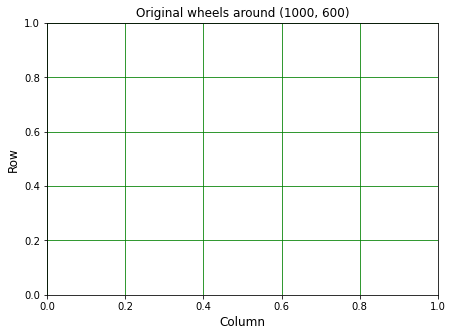

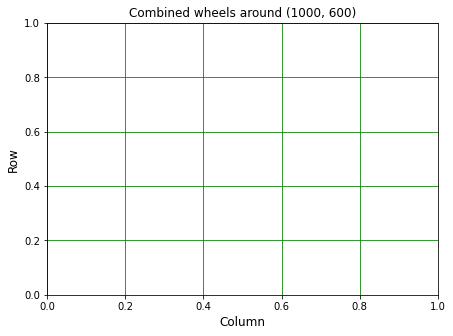

 
Date and time 2021-01-29 17:22:30.289035
Time since last check is 0:00:00.282225


In [40]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
plotC = 1000  # x axis
plotR = 600  # y axis
#
plotRange = 50
#
blackRims = True
#
minPnts = 0
#
withLabels = True
wTextRow = 0
wTextCol = 0
rTextRow = 0
rTextCol = 0
#
print(" ")
fig = plt.figure(figsize=(7, 5))
plt.title("Original wheels around (" + str(plotC) + ", " + str(plotR) + ")", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
iCol = 0
for nT in range(0, nThresh):
    for iWheel in range(0, nWheel[nT]):
        rMin = np.amin(wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT])
        cMin = np.amin(wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT])
        rMax = np.amax(wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT])
        cMax = np.amax(wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT])
        if (rMin > plotR + plotRange or rMax < plotR - plotRange or 
            cMin > plotC + plotRange or cMax < plotC - plotRange):
            continue
        print("Original wheel in search range index",iWheel)
        plt.scatter(wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT], wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT], 
                    s = 10, color = colList[iCol])
        if withLabels:
            rLab = rMin - wTextRow
            cLab = cMin - wTextCol
            plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
        iCol = iCol + 1
        if iCol > nColors - 1:
            iCol = 0
        #
        if nRimPnts[iWheel, nT] < minPnts:
            continue
        if blackRims:
            plt.scatter(rimC[iWheel, 0:nRimPnts[iWheel, nT], nT], rimR[iWheel, 0:nRimPnts[iWheel, nT], nT], 
                        s = 1, color = 'k')
        else:
            plt.scatter(rimC[iWheel, 0:nRimPnts[iWheel, nT], nT], rimR[iWheel, 0:nRimPnts[iWheel, nT], nT], 
                        s = 1, color = colList[iCol])
            iCol = iCol + 1
            if iCol > nColors - 1:
                iCol = 0
        if withLabels:
            rLab = rMax + rTextRow
            cLab = cMax + rTextCol
            plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
        #
    #
plt.grid(color = 'g')
plt.show()
print(" ")
fig = plt.figure(figsize=(7, 5))
plt.title("Combined wheels around (" + str(plotC) + ", " + str(plotR) + ")", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
iCol = 0
for nT in range(0, nThresh):
    for iWheel in range(0, nWheelN[nT]):
        rMin = np.amin(wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
        cMin = np.amin(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
        rMax = np.amax(wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
        cMax = np.amax(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
        if (rMin > plotR + plotRange or rMax < plotR - plotRange or 
            cMin > plotC + plotRange or cMax < plotC - plotRange):
            continue
        print("Combined wheel in search range index",iWheel," threshold " + str(thresh[nT]))
        plt.scatter(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], 
                    s = 10, color = colList[iCol])
        if withLabels:
            rLab = rMin - wTextRow
            cLab = cMin - wTextCol
            plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
        iCol = iCol + 1
        if iCol > nColors - 1:
            iCol = 0
        #
        if nRimPnts[iWheel, nT] < minPnts:
            continue
        if blackRims:
            plt.scatter(rimCN[iWheel, 0:nRimPntsN[iWheel, nT], nT], rimRN[iWheel, 0:nRimPntsN[iWheel, nT], nT], 
                        s = 1, color = 'k')
        else:
            plt.scatter(rimCN[iWheel, 0:nRimPntsN[iWheel, nT], nT], rimRN[iWheel, 0:nRimPntsN[iWheel, nT], nT], 
                        s = 1, color = colList[iCol])
            iCol = iCol + 1
            if iCol > nColors - 1:
                iCol = 0
        if withLabels:
            rLab = rMax + rTextRow
            cLab = cMax + rTextCol
            plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
        #
    #
plt.grid(color = 'g')
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make plot of rims and wheels selected by index

Plot rims and wheels selected using their indices, as shown in the above plots (if `withLabels = True`).

Date and time 2021-01-29 17:22:30.304991
 
Plots after combination


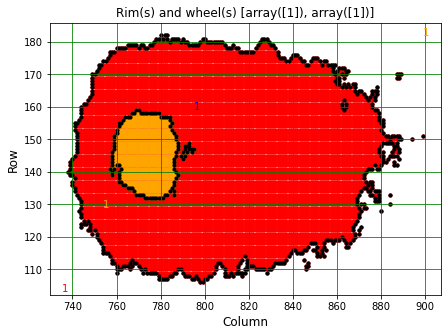

 
Date and time 2021-01-29 17:22:30.497465
Time since last check is 0:00:00.192474


In [41]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
# Required rims/wheels for each threshold; first row first threshold, second row second threshold (etc.).
iList = np.array([[1],[1]])
#
afterCombination = True
blackRims = True
#
withLabels = True
wTextRow = 3
wTextCol = 3
cTextRow = 0
cTextCol = 0
#
fig = plt.figure(figsize=(7.0, 5.0))
aList = [iList[nT] for nT in range(0, nThresh)]
plt.title("Rim(s) and wheel(s) " + str(aList), fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
iCol = 0
print(" ")
if afterCombination:
    print("Plots after combination")
else:
    print("Plots before combination")
#
for nT in range(0, nThresh):
    #
    if afterCombination:
        for iWheel in iList[nT]: 
            plt.scatter(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT], 
                        s = 10, color = colList[iCol])
            if withLabels:
                rMin = np.amin(wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
                cMin = np.amin(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
                rMax = np.amax(wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
                cMax = np.amax(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
                rLab = rMin - wTextRow
                cLab = cMin - wTextCol
                plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
            iCol = iCol + 1
            if iCol > nColors - 1:
                iCol = 0
            if nRimPntsN[iWheel, nT] < minPnts:
                continue
            if blackRims:
                plt.scatter(rimCN[iWheel, 0:nRimPntsN[iWheel, nT], nT], rimRN[iWheel, 0:nRimPntsN[iWheel, nT], nT], 
                            s = 10, color = 'k')
                rLab = rMax + rTextRow
                cLab = cMax + rTextCol
                plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
            else:
                plt.scatter(rimCN[iWheel, 0:nRimPntsN[iWheel, nT], nT], rimRN[iWheel, 0:nRimPntsN[iWheel, nT], nT], 
                            s = 10, color = colList[iCol])
                rLab = rMax + rTextRow
                cLab = cMax + rTextCol
                plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
                iCol = iCol + 1
                if iCol > nColors - 1:
                    iCol = 0
    else:
        for iWheel in iList[nT]: 
            plt.scatter(wheelC[iWheel, 0:nWheelPnts[iWheel, nT], nT], wheelR[iWheel, 0:nWheelPnts[iWheel, nT], nT], 
                        s = 10, color = colList[iCol])
            if withLabels:
                rMin = np.amin(wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
                cMin = np.amin(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
                rMax = np.amax(wheelRN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
                cMax = np.amax(wheelCN[iWheel, 0:nWheelPntsN[iWheel, nT], nT])
                rLab = rMin - wTextRow
                cLab = cMin - wTextCol
                plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
            iCol = iCol + 1
            if iCol > nColors - 1:
                iCol = 0
            if nRimPnts[iWheel, nT] < minPnts:
                continue
            if blackRims:
                plt.scatter(rimC[iWheel, 0:nRimPnts[iWheel, nT], nT], rimR[iWheel, 0:nRimPnts[iWheel, nT], nT], 
                            s = 10, color = 'k')
                rLab = rMax + rTextRow
                cLab = cMax + rTextCol
                plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
            else:
                plt.scatter(rimC[iWheel, 0:nRimPnts[iWheel, nT], nT], rimR[iWheel, 0:nRimPnts[iWheel, nT], nT], 
                            s = 10, color = colList[iCol])
                rLab = rMax + rTextRow
                cLab = cMax + rTextCol
                plt.text(cLab, rLab, str(iWheel), color = colList[iCol])
                iCol = iCol + 1
                if iCol > nColors - 1:
                    iCol = 0
    #
plt.grid(color = 'g')
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Select wheels/rims by combining results from all thresholds

Thresholds must increase monotonically in the following. Select only low threshold rims/wheels containing one high threshold rim.

Further 

Produce and sort lists of coordinates that will be put into json file as "polygons". Sort according to angle of points about centre of rim. Choose centre to be mean position of high threshold enclosed by the low threshold rim, or the mean position of the pixels in the low threshold rim.

Note that need to add first point to end of sorted list to close the polygon!

Date and time  2021-01-29 17:22:30.534364
 
Number of selected rims 7


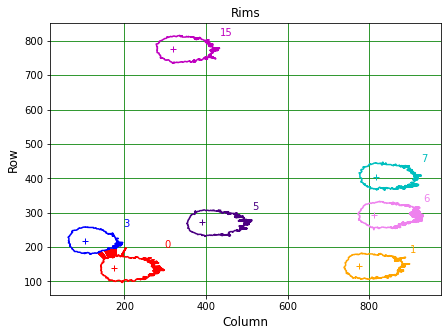

 
Number of polygons (nRimOut) 7
 


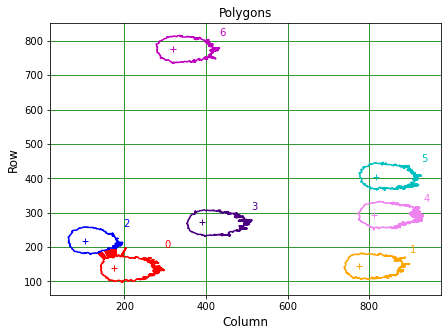

 
Date and time 2021-01-29 17:22:30.834540
Time since last check is 0:00:00.300176


In [42]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
# Choose low threshold or high threshold rim as centre in sorting procedure
centreLT = False
#
minRimPnts0 = 100
minWheelPnts0 = 500
rMin0 = 5
rMax0 = nRows - rMin0
cMin0 = 5
cMax0 = nCols - cMin0
rWidMin0 = 20
rWidMax0 = 200
cWidMin0 = 50
cWidMax0 = 500
maxRtoW = 0.1
#
pnts_num = np.zeros(nRimN[0]).astype(int)
pnts_row = np.zeros((nRimN[0], np.amax(nRimPntsN[:, 0])))
pnts_col = np.zeros((nRimN[0], np.amax(nRimPntsN[:, 0])))
mean_row = np.zeros(nRimN[0])
mean_col = np.zeros(nRimN[0])
#
# Need additional entry in sorted arrays as must add initial point at end of array to complete polygon!
col_sorted = np.zeros((nRimN[0], np.amax(nRimPntsN[:, 0]) + 1))
row_sorted = np.zeros((nRimN[0], np.amax(nRimPntsN[:, 0]) + 1))
#
rTextRow = 0
rTextCol = 0
#
fig = plt.figure(figsize=(7, 5))
plt.title("Rims", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
iCol = 0
#
iSelRim = 0
for iRimT in range(0, nRimN[0]):
    rWidT = np.amax(rimRN[iRimT, 0:nRimPntsN[iRimT, 0], 0]) - np.amin(rimRN[iRimT, 0:nRimPntsN[iRimT, 0], 0])
    cWidT = np.amax(rimCN[iRimT, 0:nRimPntsN[iRimT, 0], 0]) - np.amin(rimCN[iRimT, 0:nRimPntsN[iRimT, 0], 0])
    #
    # Check rims and wheels have enough points, are removed from image edges and are of an acceptable size
    if (nRimPntsN[iRimT, 0] < minRimPnts0 or nWheelPntsN[iRimT, 0] < minWheelPnts0 or
        np.amin(rimRN[iRimT, 0:nRimPntsN[iRimT, 0], 0]) < rMin0 or  
        np.amax(rimRN[iRimT, 0:nRimPntsN[iRimT, 0], 0]) > rMax0 or  
        np.amin(rimCN[iRimT, 0:nRimPntsN[iRimT, 0], 0]) < cMin0 or  
        np.amax(rimCN[iRimT, 0:nRimPntsN[iRimT, 0], 0]) > cMax0 or
        rWidT < rWidMin0 or rWidT > rWidMax0 or cWidT < cWidMin0 or cWidT > cWidMax0): 
        continue
    #
    rMinT = np.amin(rimRN[iRimT, 0:nRimPntsN[iRimT, 0], 0])
    cMinT = np.amin(rimCN[iRimT, 0:nRimPntsN[iRimT, 0], 0])
    rMaxT = np.amax(rimRN[iRimT, 0:nRimPntsN[iRimT, 0], 0])
    cMaxT = np.amax(rimCN[iRimT, 0:nRimPntsN[iRimT, 0], 0])
    #
    inRimT = 0
    for nT in range(1, nThresh):
        for iRim in range(0, nRimN[nT]):
            rMin = np.amin(rimRN[iRim, 0:nRimPntsN[iRim, nT], nT])
            cMin = np.amin(rimCN[iRim, 0:nRimPntsN[iRim, nT], nT])
            rMax = np.amax(rimRN[iRim, 0:nRimPntsN[iRim, nT], nT])
            cMax = np.amax(rimCN[iRim, 0:nRimPntsN[iRim, nT], nT])
            ratioRtoW = nRimPntsN[iRimT, 0]/nWheelPntsN[iRimT, 0]
            #
            # Find any high threshold rims completely within the low threshold rim
            if (rMin > rMinT and rMax < rMaxT and cMin > cMinT and cMax < cMaxT and ratioRtoW < maxRtoW):
                inRimT += 1
                nTselect = nT
                iRimSelect = iRim
    if inRimT == 1:
        # 
        # This rim accepted
        pnts_num[iSelRim] = nRimPntsN[iRimT, 0]
        pnts_row[iSelRim, 0:nRimPntsN[iRimT, 0]] = rimRN[iRimT, 0:nRimPntsN[iRimT, 0], 0].astype(int)
        pnts_col[iSelRim, 0:nRimPntsN[iRimT, 0]] = rimCN[iRimT, 0:nRimPntsN[iRimT, 0], 0].astype(int)
        # 
        # Choose desired rim centre for definition of angle used for sorting rim points
        if centreLT:
            mean_row[iSelRim] = np.mean(pnts_row[iSelRim, 0:pnts_num[iSelRim]])
            mean_col[iSelRim] = np.mean(pnts_col[iSelRim, 0:pnts_num[iSelRim]])
        else:
            mean_row[iSelRim] = np.mean(rimRN[iRimSelect, 0:nRimPntsN[iRimSelect, nTselect], nTselect])
            mean_col[iSelRim] = np.mean(rimCN[iRimSelect, 0:nRimPntsN[iRimSelect, nTselect], nTselect])
        #
        atan_pnts = np.arctan2(pnts_col[iSelRim, 0:pnts_num[iSelRim]] - mean_col[iSelRim],
                               pnts_row[iSelRim, 0:pnts_num[iSelRim]] - mean_row[iSelRim])
        ind_sort = np.argsort(atan_pnts)
        #
        col_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_col[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
        row_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_row[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
        plt.plot(col_sorted[iSelRim, 0:pnts_num[iSelRim]], row_sorted[iSelRim, 0:pnts_num[iSelRim]],
                    color = colList[iCol])
        plt.plot(mean_col[iSelRim], mean_row[iSelRim], marker = '+', color = colList[iCol])
        if withLabels:
            row_label = np.amax(pnts_row[iSelRim, 0:pnts_num[iSelRim]]) + rTextRow
            col_label = np.amax(pnts_col[iSelRim, 0:pnts_num[iSelRim]]) + rTextCol
            plt.text(col_label, row_label, str(iRimT), color = colList[iCol])
        iCol = iCol + 1
        if iCol > nColors - 1:
            iCol = 0
        #
        iSelRim += 1
    #
#
print(" ")
print("Number of selected rims",iSelRim)
plt.grid(color = 'g')
plt.show()
#
nRimOut = iSelRim
print(" ")
print("Number of polygons (nRimOut)",nRimOut)
#
fig = plt.figure(figsize=(7, 5))
plt.title("Polygons", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
iCol = 0
#
# Add first point (index zero) to end of array to ensure completion of polygon and then plot!
for iRim in range(0, nRimOut):
    col_sorted[iRim, pnts_num[iRim]] = col_sorted[iRim, 0]
    row_sorted[iRim, pnts_num[iRim]] = row_sorted[iRim, 0]
    pnts_num[iRim] += 1
    plt.plot(col_sorted[iRim, 0:pnts_num[iRim]], row_sorted[iRim, 0:pnts_num[iRim]],
                color = colList[iCol])
    plt.plot(mean_col[iRim], mean_row[iRim], marker = '+', color = colList[iCol])
    if withLabels:
        row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]]) + rTextRow
        col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]]) + rTextCol
        plt.text(col_label, row_label, str(iRim), color = colList[iCol])
    iCol = iCol + 1
    if iCol > nColors - 1:
        iCol = 0
#
print(" ")
plt.grid(color = 'g')
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make json file

In [43]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
from IPython.display import JSON
import os
#
im_file = imFile
im_file_size = os.path.getsize(im_file)
dict_name = im_file + str(im_file_size)
number_comets = nRimOut
#
comets = {}
comets[dict_name] = {
    "fileref": "",
    "size": im_file_size,
    "filename": im_file,
    "base64_img_data": "",
    "file_attributes": {},
    "regions": {str(n_comet):
                {"shape_attributes":
                 {"name": "polygon",
                  "all_points_x":
                  col_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                  "all_points_y":
                  row_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                 "region_attributes": {}}}
                for n_comet in range(0, number_comets)}
}
#
out_file_name = 'comets.json'
with open(out_file_name, 'w') as outfile:
    json.dump(comets, outfile)
#
out_file_size = os.path.getsize(out_file_name)
print(" ")
print("im_file_size",im_file_size)
print("dict_name",dict_name)
print("out_file_size",out_file_size)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-01-29 17:22:30.849823
 
im_file_size 1448758
dict_name Images/IrradiatedBatch/0020.bmp1448758
out_file_size 37935
 
Date and time 2021-01-29 17:22:30.861757
Time since last check is 0:00:00.011934


## Look at json file

In [44]:
JSON(comets)

<IPython.core.display.JSON object>

## Plot polygons

Make plot of all polygon in json file.

Date and time  2021-01-29 17:22:30.898688
 


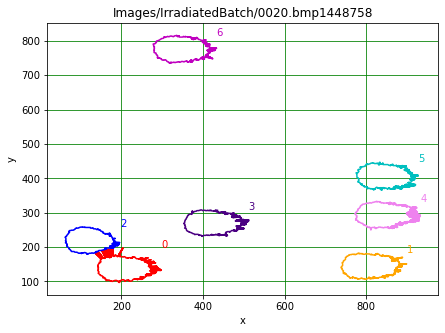

 
Date and time 2021-01-29 17:22:31.059226
Time since last check is 0:00:00.160538


In [45]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import pandas as pd
#
withLabels = True
#
json_file = 'comets.json'
polygons_df = pd.read_json(json_file)
#
# Set up colour list for plots
n_colours = 8
colour_list = ['r', 'orange', 'b', 'indigo', 'violet', 'c', 'm', 'k']
#
rTextRow = 0
rTextCol = 0
#
# Loop over all files in the dataframe
iPoly = 0
for file in polygons_df:
    #
    # Make figure for each file
    plt.figure(figsize = (7, 5))
    plt.title(file)
    plt.xlabel("x")
    plt.ylabel("y")
    n_col = 0
    for key in polygons_df[file]['regions']:
        #
        # Extract coordinates of polygons and plot
        x_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        y_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        plt.plot(x_coords, y_coords, linestyle = '-', color = colour_list[n_col])
        plt.grid(color = 'g')
        #
        if withLabels:
            row_label = np.amax(y_coords) + rTextRow
            col_label = np.amax(x_coords) + rTextCol
            plt.text(col_label, row_label, str(key), color = colour_list[n_col])
        #
        n_col += 1
        if n_col == n_colours:
            n_col = 0
        #
    print(" ")
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot individual polygons

Male plot of each of comets in json file (compare scatter plot with plot of line generating polygon).

Date and time  2021-01-29 17:22:31.070189
 


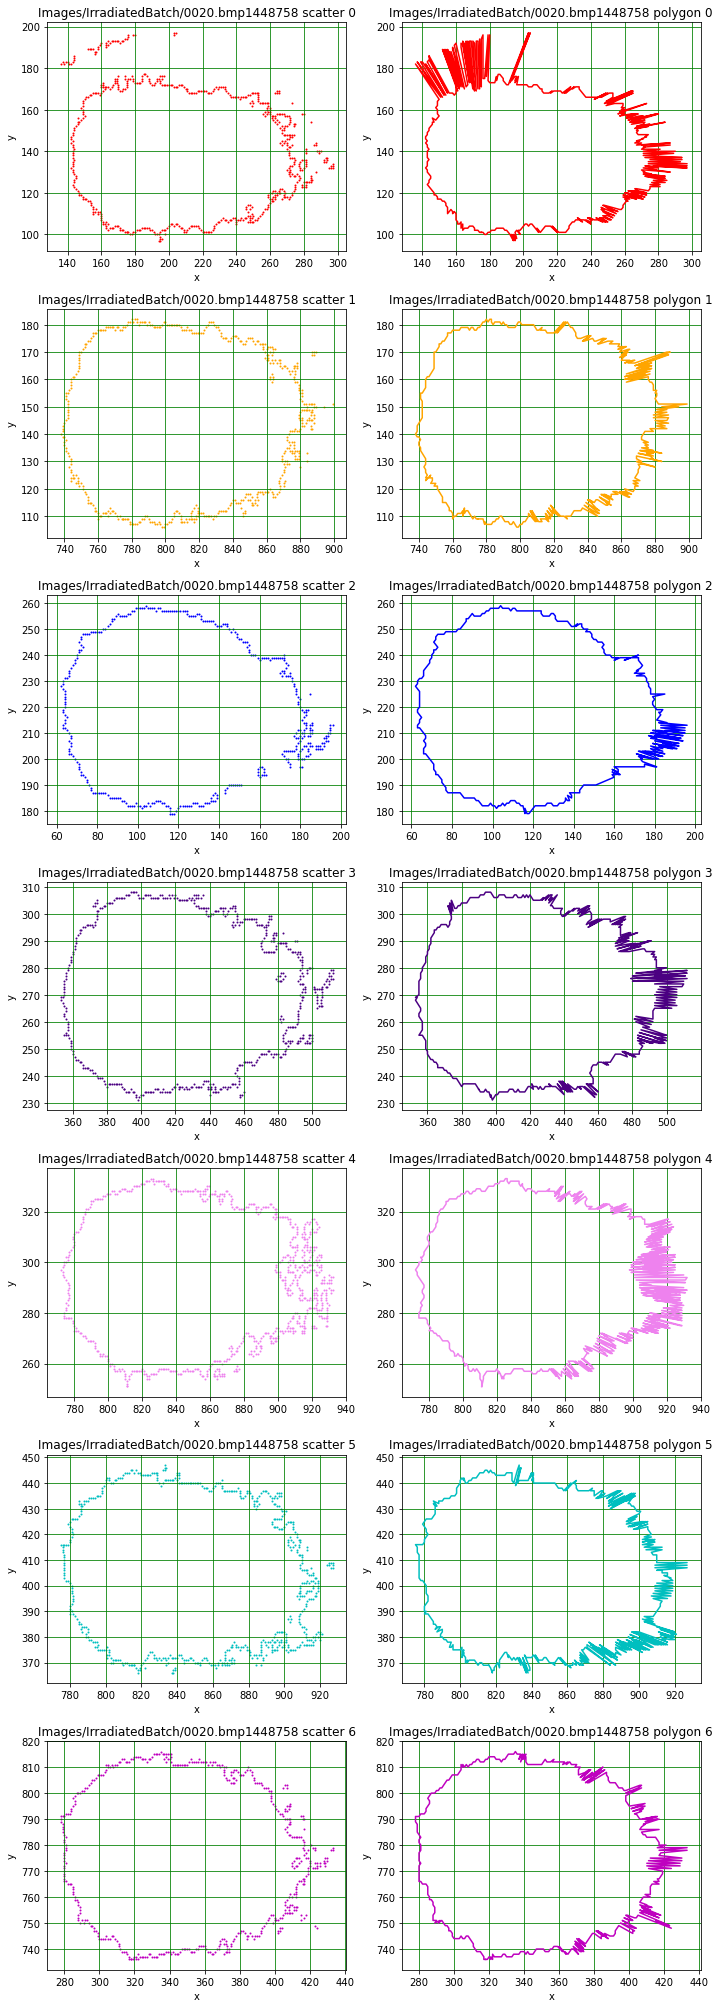

 
Date and time 2021-01-29 17:22:33.237272
Time since last check is 0:00:02.167083
Time since notebook start is 0:00:19.407043


In [46]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
# Loop over all files in the dataframe
for index, file in enumerate(polygons_df):
    #
    # Make figure for each comet
    print(" ")
    number_comets = len(polygons_df[file]['regions'])
    fig1, axs = plt.subplots(number_comets, 2, figsize = (10, 4*number_comets))
    n_plot = 0
    n_col = 0
    #
    for key in polygons_df[file]['regions']:
        #
        # Extract coordinates of polygons and plot
        x_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        y_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        #
        axs[int(key), 0].set_title(file + " scatter " + key)
        axs[int(key), 0].set_xlabel("x")
        axs[int(key), 0].set_ylabel("y")
        axs[int(key), 0].scatter(x_coords, y_coords, s = 1.0, color = colour_list[n_col])
        axs[int(key), 0].grid(color = 'g')
        #
        axs[int(key), 1].set_title(file + " polygon " + key)
        axs[int(key), 1].set_xlabel("x")
        axs[int(key), 1].set_ylabel("y")
        axs[int(key), 1].plot(x_coords, y_coords, linestyle = '-', color = colour_list[n_col])
        axs[int(key), 1].grid(color = 'g')
        #
        n_col += 1
        if n_col == n_colours:
            n_col = 0
        #
    plt.tight_layout()
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))